# LSTM

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.covariance import EllipticEnvelope
import collections
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

In [11]:
data = pd.read_csv('CSC215_P2_Stock_Price.csv')
#data.drop(['Date','Adj Close'], axis=1, inplace=True)
data

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
...,...,...,...,...,...,...,...
4387,2017/9/1,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,2017/9/5,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,2017/9/6,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,2017/9/7,112.459999,112.900002,112.000000,112.339996,112.339996,1251600


In [12]:
data.drop(['Date','Adj_Close'], axis=1, inplace=True)
#data.drop(['Date','Adj Close'], axis=1, inplace=True)

In [13]:
data['y'] = data['Close']
data

,Open,High,Low,Close,Volume,y
0,3.812500,4.156250,3.812500,4.125000,3675600,4.125000
1,4.125000,4.125000,4.000000,4.015625,1077600,4.015625
2,4.000000,4.031250,3.953125,4.000000,437200,4.000000
3,4.000000,4.000000,3.843750,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,3.390625,7931600,3.390625
...,...,...,...,...,...,...
4387,113.790001,114.099998,112.790001,113.309998,950000,113.309998
4388,112.519997,113.529999,111.160004,111.870003,1805200,111.870003
4389,112.029999,112.489998,110.250000,112.230003,2136700,112.230003
4390,112.459999,112.900002,112.000000,112.339996,1251600,112.339996


In [14]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    
    plt.show()

In [15]:
def to_sequences(seq_size, data1, data2):
    x = []
    
    y = []

    for i in range(len(data1)-seq_size):
        #print(i)
        window = data1[i:(i+seq_size)]
        after_window = data2[i+seq_size]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)

In [16]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [17]:
encode_numeric_zscore(data,'Open')
encode_numeric_zscore(data,'High')
encode_numeric_zscore(data,'Low')
encode_numeric_zscore(data,'Close')
#encode_numeric_zscore(dataFrame,'Adj Close')
encode_numeric_zscore(data,'Volume')

In [18]:
data

,Open,High,Low,Close,Volume,y
0,-0.894209,-0.885022,-0.892306,-0.884364,1.104812,4.125000
1,-0.883762,-0.886056,-0.885975,-0.888021,-0.497301,4.015625
2,-0.887941,-0.889159,-0.887558,-0.888543,-0.892217,4.000000
3,-0.887941,-0.890194,-0.891251,-0.893768,-0.000263,3.843750
4,-0.896820,-0.898986,-0.906551,-0.908920,3.729366,3.390625
...,...,...,...,...,...,...
4387,2.782154,2.754177,2.787407,2.766603,-0.575988,113.309998
4388,2.739700,2.735310,2.732368,2.718452,-0.048610,111.870003
4389,2.723320,2.700885,2.701641,2.730490,0.155816,112.230003
4390,2.737694,2.714457,2.760732,2.734168,-0.390000,112.339996


In [19]:
y = data[['y']].copy()
x = data.drop(['y'], axis = 1)

In [20]:
x.shape

(4392, 5)

In [21]:
x.shape,y.shape

((4392, 5), (4392, 1))

In [22]:
x = np.array(x, dtype=np.float32)
y = np.array(data['y'].values, dtype=np.float32)

In [23]:
#y = data['y'].values

In [24]:
y

array([  4.125   ,   4.015625,   4.      , ..., 112.23    , 112.34    ,
       113.19    ], dtype=float32)

In [25]:
x.shape,y.shape

((4392, 5), (4392,))

In [26]:
SEQUENCE_SIZE = 7

x_LSTM,y_LSTM = to_sequences(SEQUENCE_SIZE,x,y)

In [27]:
x_LSTM.shape,y_LSTM.shape

((4385, 7, 1, 5), (4385,))

In [29]:
x_LSTM=x_LSTM.reshape(4385,7,5)
#y_cnn=y_cnn.reshape(y_cnn.shape[0])

In [30]:
y_LSTM.shape

(4385,)

In [31]:
#x_cnn,y_cnn =to_sequences(SEQUENCE_SIZE,x,y)
x_train, x_test, y_train, y_test = train_test_split(x_LSTM, y_LSTM, test_size=0.25, random_state=33)

In [32]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3288, 7, 5), (1097, 7, 5), (3288,), (1097,))

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

model = Sequential()

model.add(LSTM(64,dropout=0.1, recurrent_dropout=0.1,  input_shape=(7, 5),activation ='relu'))

model.add(Dense(20))
model.add(Dense(1))



model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2,epochs = 1000)

Train...
Train on 3288 samples, validate on 1097 samples
Epoch 1/1000
3288/3288 - 8s - loss: 851.5486 - val_loss: 273.7306
Epoch 2/1000
3288/3288 - 2s - loss: 72.7275 - val_loss: 12.4552
Epoch 3/1000
3288/3288 - 2s - loss: 29.9856 - val_loss: 14.4086
Epoch 4/1000
3288/3288 - 2s - loss: 24.0482 - val_loss: 15.1119
Epoch 00004: early stopping


Score_train (RMSE): 3.6882989406585693
Score_rest (RMSE): 3.887402296066284


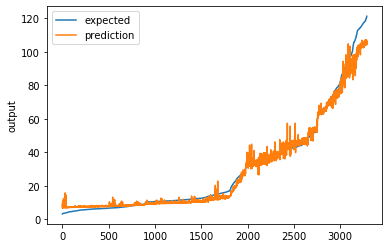

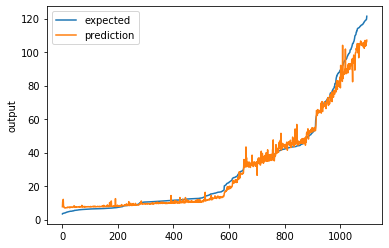

In [35]:
from sklearn import metrics

pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_rest (RMSE): {}".format(score_test))


chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)

# LSTM using Bidirectional

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(64,dropout=0.1,activation ='relu',  return_sequences=True),input_shape=(7,5)))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(1))
#model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor],verbose=2,epochs = 1000)

Train...
Train on 3288 samples, validate on 1097 samples
Epoch 1/1000


In [ ]:
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [ ]:
from sklearn import metrics

pred_train = model.predict(x_train)
score_train = np.sqrt(metrics.mean_squared_error(pred_train,y_train))
print("Score_train (RMSE): {}".format(score_train))

pred_test = model.predict(x_test)
score_test = np.sqrt(metrics.mean_squared_error(pred_test,y_test))
print("Score_rest (RMSE): {}".format(score_test))


chart_regression(pred_train.flatten(),y_train, sort=True)
chart_regression(pred_test.flatten(),y_test, sort=True)